In [3]:
!gdown --id 1GaTMURqIQTjtalbNVAyVgPIEis21A0r8

C:\Users\ADMIN\anaconda3\envs\aio_exercise\lib\site-packages\gdown\__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1GaTMURqIQTjtalbNVAyVgPIEis21A0r8
From (redirected): https://drive.google.com/uc?id=1GaTMURqIQTjtalbNVAyVgPIEis21A0r8&confirm=t&uuid=337beb72-59fa-44e7-a272-5946f0ec5bf9
To: c:\Users\ADMIN\OneDrive - VNU-HCMUS\Old Laptop\AIO2024\Main Class\AIO-Exercise\Module_5\Week_3\FER-2013.zip

  0%|          | 0.00/63.3M [00:00<?, ?B/s]
  1%|          | 524k/63.3M [00:00<00:30, 2.03MB/s]
  2%|▏         | 1.05M/63.3M [00:00<00:20, 3.09MB/s]
  2%|▏         | 1.57M/63.3M [00:00<00:17, 3.53MB/s]
  3%|▎         | 2.10M/63.3M [00:00<00:19, 3.15MB/s]
  4%|▍         | 2.62M/63.3M [00:00<00:18, 3.31MB/s]
  5%|▍         | 3.15M/63.3M [00:00<00:16, 3.57MB/s]
  6%|▌         | 3.67M/63.3M [00:01<00:18, 3.24MB/s

In [8]:
import zipfile

zip_path = './FER-2013.zip'
with zipfile.ZipFile(zip_path, 'r') as f:
    f.extractall('./')

In [28]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
from torchvision.io import read_image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

In [30]:
train_dir = './train'
test_dir = './test'

classes = os.listdir(train_dir)

label2idx = {cls: idx for idx, cls in enumerate(classes)}

idx2label = {idx: cls for idx, cls in enumerate(classes)}
label2idx

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [31]:
img_height, img_width = (128, 128)

class ImageDataset(Dataset):
    def __init__(self, img_dir, norm, label2idx, split = 'train', train_ratio = 0.8):
        self.resize = Resize((img_height, img_width))
        self.norm = norm
        self.split = split
        self.train_ratio = train_ratio
        self.img_dir = img_dir
        self.label2idx = label2idx
        self.img_paths, self.img_labels = self.read_img_files()
        
        if split in ['train', 'val'] and 'train' in img_dir.lower():
            train_data, val_data = train_test_split(
                list(zip(self.img_paths, self.img_labels)),
                train_size=train_ratio,
                random_state=random_state,
                stratify=self.img_labels
            )
            if split == 'train':
                self.img_paths, self.img_labels = zip(*train_data)
            elif split == 'val':
                self.img_paths, self.img_labels = zip(*val_data)
    
    def read_img_files(self):
        img_paths = []
        img_labels = []
        for cls in self.label2idx.keys():
            for img in os.listdir(os.path.join(self.img_dir, cls)):
                img_paths.append(os.path.join(self.img_dir, cls, img))
                img_labels.append(cls)
        return img_paths, img_labels
    
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = self.resize(read_image(img_path))
        img = img.type(torch.float32)
        
        cls = self.img_labels[idx]
        label = label2idx[cls]
        if self.norm:
            img = (img / 127.5) - 1
        return img, label

In [32]:
batch_size = 256
train_dataset = ImageDataset(train_dir, True,
                             label2idx, split='train')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = ImageDataset(train_dir, True, label2idx, split='val')
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = ImageDataset(test_dir, True, label2idx, split='test')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


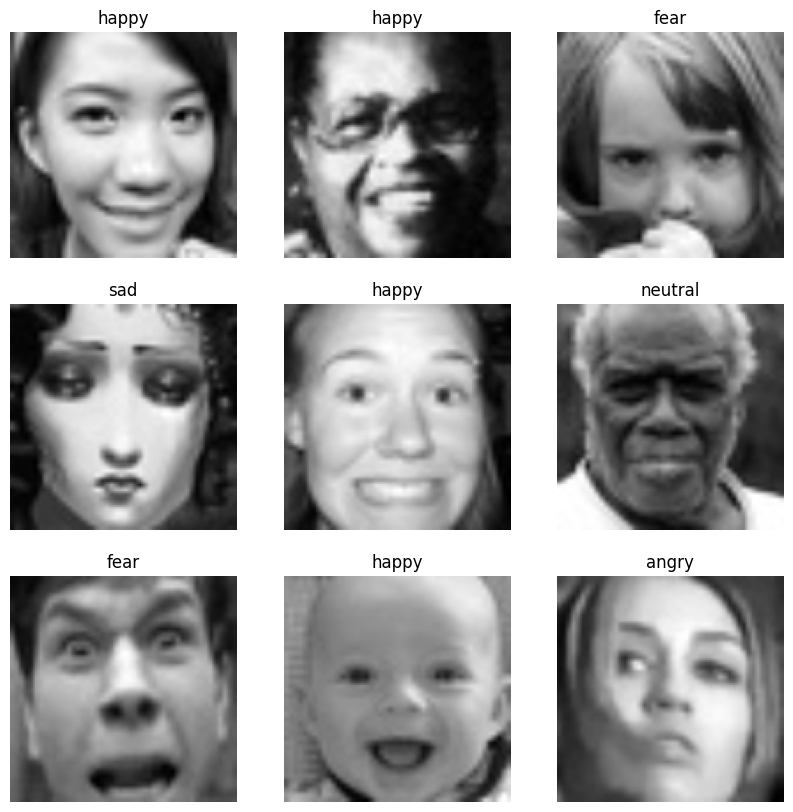

In [33]:
image_batch, label_batch = next(iter(train_loader))

plt.figure(figsize=(10, 10))
for i in range(0, 9):
    ax = plt.subplot(3, 3, i + 1)
    minv = image_batch[i].numpy().min()
    maxv = image_batch[i].numpy().max()
    plt.imshow(np.squeeze(image_batch[i].numpy()), vmin=minv, vmax=maxv, cmap="gray")
    label = label_batch[i]
    plt.title(idx2label[label.item()])
    plt.axis("off")

In [34]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super().__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims*4)
        self.linear2 = nn.Linear(hidden_dims*4, hidden_dims*2)
        self.linear3 = nn.Linear(hidden_dims*2, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
    
    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x)
        out = self.output(x)
        return out.squeeze(1)
    
input_dims = img_height * img_width
output_dims = len(classes)
hidden_dims = 64
lr = 1e-2

model = MLP(input_dims, hidden_dims, output_dims).to(device)

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [36]:
def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim = 1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct / len(y_true)
    return accuracy

In [39]:
epochs = 40
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_predict = []
    model.train() # start train
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad() # reset grad
        outputs = model(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step() # update para
        train_loss += loss.item()

        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)
    
    val_loss = 0.0
    val_target = []
    val_predict = []
    model.eval() # set model to evaluation
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            
            loss = criterion(outputs, y_samples)
            val_loss += loss.item()

            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict,val_target)
    val_accs.append(val_acc)
    print(f'\nEPOCH {epoch + 1}:\tTraining loss: {train_loss: .3f}\tValidation loss: {val_loss: .3f}')


EPOCH 1:	Training loss:  1.753	Validation loss:  1.746

EPOCH 2:	Training loss:  1.732	Validation loss:  1.724

EPOCH 3:	Training loss:  1.709	Validation loss:  1.702

EPOCH 4:	Training loss:  1.687	Validation loss:  1.683

EPOCH 5:	Training loss:  1.668	Validation loss:  1.669

EPOCH 6:	Training loss:  1.653	Validation loss:  1.659

EPOCH 7:	Training loss:  1.640	Validation loss:  1.648

EPOCH 8:	Training loss:  1.629	Validation loss:  1.642

EPOCH 9:	Training loss:  1.619	Validation loss:  1.632

EPOCH 10:	Training loss:  1.610	Validation loss:  1.626

EPOCH 11:	Training loss:  1.600	Validation loss:  1.620

EPOCH 12:	Training loss:  1.592	Validation loss:  1.614

EPOCH 13:	Training loss:  1.583	Validation loss:  1.610

EPOCH 14:	Training loss:  1.575	Validation loss:  1.603

EPOCH 15:	Training loss:  1.567	Validation loss:  1.598

EPOCH 16:	Training loss:  1.559	Validation loss:  1.598

EPOCH 17:	Training loss:  1.552	Validation loss:  1.593

EPOCH 18:	Training loss:  1.543	Validat

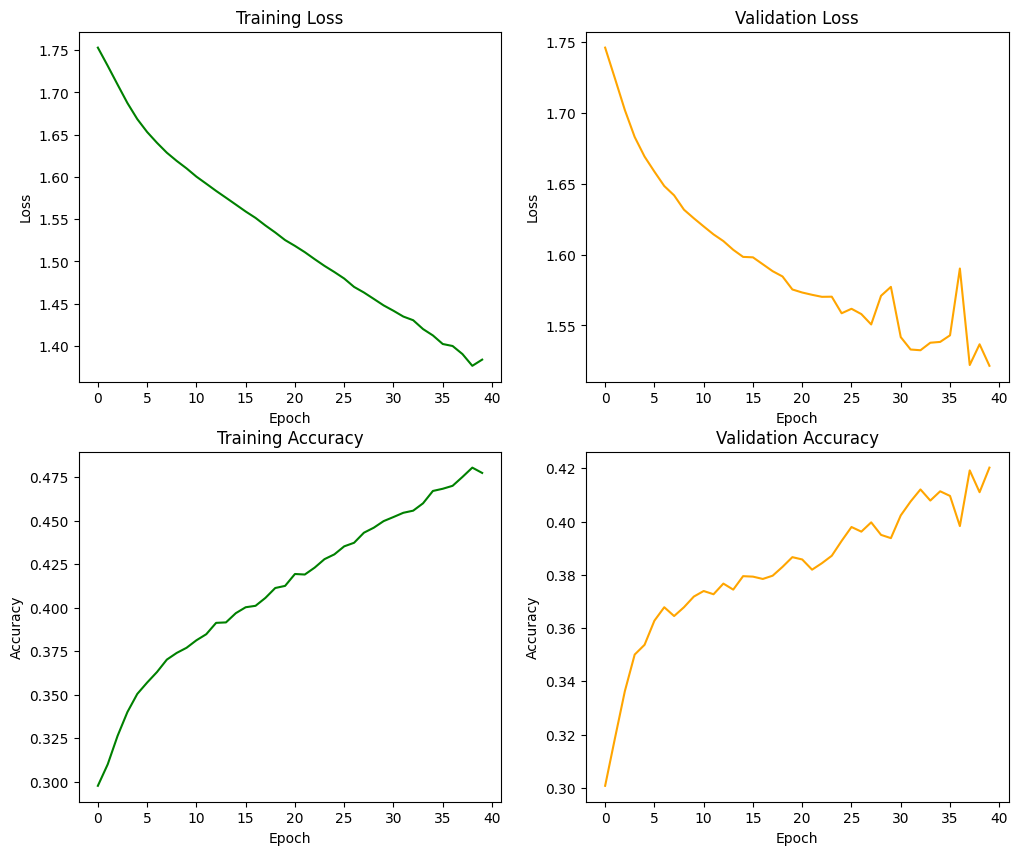

In [40]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

In [41]:
test_target = []
test_predict = []

model.eval() # set model to evaluation
with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)
        
        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())

    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    test_acc = compute_accuracy(test_predict,test_target)
    print('Evaluation of test set:')
    print(f'Accuracy: {test_acc}')

Evaluation of test set:
Accuracy: 0.4196154917804402
